In [1]:
from pathlib import Path
import sys

import numpy as np
import sklearn.ensemble
import sklearn.metrics
import sklearn.calibration
from sklearn.datasets import make_classification
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

from deep_forest.weak_labels import SCARImputer
from deep_forest import tice
sys.path.insert(0, "..")
from positive_dropper import PositiveDropper

RANDOM_STATE = 0

In [2]:
from sklearn.ensemble._forest import (
    _generate_unsampled_indices,
    _get_n_samples_bootstrap,
)

def get_c_estimates(tree, X, y, delta=0.025):
    paths = tree.decision_path(X).toarray()
    n = paths.sum(axis=0)
    n_labeled = paths[y.astype(bool).reshape(-1)].sum(axis=0)

    n_labeled = n_labeled[n != 0]
    n = n[n != 0]
    # eff_delta = 1 / (1 + 0.004 * n)
    # eff_delta = np.clip(eff_delta, delta, 1)
    eff_delta = delta

    cc = n_labeled / n - 0.5 * np.sqrt((1 - eff_delta) / (eff_delta * n))
    return cc

def get_c_from_oob(forest, X, y, delta=0.025):
    n_samples_bootstrap = _get_n_samples_bootstrap(X.shape[0], forest.max_samples)
    cc = []
    for tree in forest.estimators_:
        unsampled_idx = _generate_unsampled_indices(
            tree.random_state, X.shape[0], n_samples_bootstrap,
        )
        cc.append(
            get_c_estimates(tree, X[unsampled_idx], y[unsampled_idx], delta)
        )
    return cc

In [4]:
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=3,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,
    weights=None,
    flip_y=0.0,
    class_sep=.5,
    hypercube=True,
    shift=0.0,
    scale=1.0,
    shuffle=True,
    random_state=RANDOM_STATE,
)
X = sklearn.preprocessing.MinMaxScaler().fit_transform(X)
y = y.reshape(-1, 1)

c1, cc1 = tice.estimate_label_frequency_lower_bound(
    X, y,
    max_bepp=5,
    n_folds=5,
    min_set_size=5,
    most_promising_only=False,
)
print(c1, cc1)

oob_imputer = SCARImputer(
    estimator=sklearn.ensemble.RandomForestClassifier(
        n_estimators=100,
        max_depth=3,
        random_state=0,
        oob_score=True,
        bootstrap=True,
        max_samples=0.5,
    ),
    verbose=True,
)

# forest = sklearn.ensemble.RandomForestClassifier(
# forest = sklearn.ensemble.RandomForestRegressor(
forest = sklearn.ensemble.ExtraTreesRegressor(
# forest = sklearn.ensemble.ExtraTreesClassifier(
    n_estimators=1000,
    max_depth=None,
    random_state=0,
    oob_score=True,
    bootstrap=True,
    max_samples=0.5,
)

# forest = sklearn.calibration.CalibratedClassifierCV(forest, cv=5, method="isotonic")


[0.5001687295195573] [[[0.49938195302843014, 0.48655256723716384, 0.49815043156596794, 0.49362244897959184, 0.5231362467866324], [0.49938195302843014, 0.48655256723716384, 0.49815043156596794, 0.49362244897959184, 0.5231362467866324]]]


Original TIcE: [0.5000495955469847] [[[0.5, 0.5074626865671642, 0.506426735218509, 0.4968394437420986, 0.48951911220715166], [0.5, 0.5074626865671642, 0.506426735218509, 0.4968394437420986, 0.48951911220715166]]]
Done: 0.0
Original TIcE: [0.4498250404282798] [[[0.4457070707070707, 0.46878824969400246, 0.4580246913580247, 0.43494897959183676, 0.44165621079046424], [0.4457070707070707, 0.46878824969400246, 0.4580246913580247, 0.43494897959183676, 0.44165621079046424]]]
Done: 0.1
Original TIcE: [0.40004939447298754] [[[0.4095940959409594, 0.3873762376237624, 0.3938223938223938, 0.3914110429447853, 0.41804320203303685], [0.4095940959409594, 0.3873762376237624, 0.3938223938223938, 0.3914110429447853, 0.41804320203303685]]]
Done: 0.2
Original TIcE: [0.3499280163653616] [[[0.3469640644361834, 0.3427835051546392, 0.3560145808019441, 0.351010101010101, 0.35286783042394015], [0.3469640644361834, 0.3427835051546392, 0.3560145808019441, 0.351010101010101, 0.35286783042394015]]]
Done: 0.30000000000

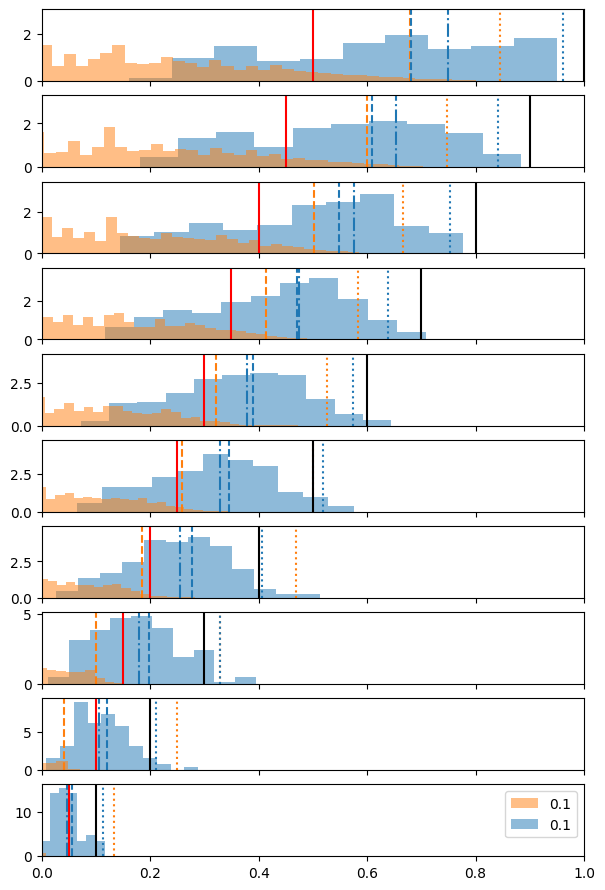

In [8]:
drop_fractions = np.linspace(0, 1, 10, endpoint=False)
n_fractions = len(drop_fractions)
fig, axs = plt.subplots(n_fractions, 1, figsize=(7, n_fractions + 1), sharex=True)

for i, drop_fraction in enumerate(drop_fractions):
    pd = PositiveDropper(drop=drop_fraction, random_state=RANDOM_STATE)
    Xt, yt = pd.fit_resample(X, y)

    if sklearn.base.is_classifier(forest):
        if hasattr(forest, "oob_decision_function_"):
            proba = forest.fit(Xt, yt.reshape(-1)).oob_decision_function_
        else:
            proba = forest.fit(Xt, yt.reshape(-1)).predict_proba(Xt)
        proba = proba[:, 1]
    else:
        if hasattr(forest, "oob_prediction_"):
            proba = forest.fit(Xt, yt.reshape(-1)).oob_prediction_
        else:
            proba = forest.fit(Xt, yt.reshape(-1)).predict(Xt)

    positives_proba = proba[yt.astype(bool).reshape(-1)]
    hist_1, bin_edges = np.histogram(
        positives_proba, bins="auto", density=True,
    )
    hist_all, _ = np.histogram(
        proba, bins=bin_edges, density=True,
    )
    width = bin_edges[1] - bin_edges[0]

    plt.xlim(0, 1)
    axs[i].bar(
        # height=hist_1 / hist_all * yt.mean(),
        height=hist_1,
        x=bin_edges[:-1],
        width=width,
        label=f"{1 - drop_fraction:.1f}",
        align="center",
        alpha=0.5,
        color="C0",
    )

    # ORIGINAL TICE ===================================================================
    c1, cc1 = tice.estimate_label_frequency_lower_bound(
        Xt, yt,
        max_bepp=5,
        n_folds=5,
        min_set_size=1,
        most_promising_only=False,
    )
    print("Original TIcE:", c1, cc1)
    axs[i].axvline(c1[0], color="red", linestyle="-")

    # TICE ===================================================================
    c_estimates = np.concatenate(get_c_from_oob(forest, Xt, yt, delta=0.1))

    plt.xlim(0, 1)
    axs[i].hist(
        c_estimates,
        bins="auto",
        label=f"{1 - drop_fraction:.1f}",
        density=True,
        alpha=0.5,
        color="C1",
    )
    print("Done:", drop_fraction)

    # axs[i].axvline(1 - drop_fraction, color="black", linestyle="-")
    axs[i].axvline(np.percentile(c_estimates, 99), color="C1", linestyle="--")
    axs[i].axvline(c_estimates.max(), color="C1", linestyle=":")
    # ========================================================================

    # plt.hist(positives_proba, bins=30, label=f"{1 - drop_fraction:.1f}")
    axs[i].axvline(np.percentile(positives_proba, 50), color="C0", linestyle="--")
    # axs[i].axvline(positives_proba.mean(), color="black", linestyle=":")
    axs[i].axvline(np.percentile(positives_proba, 95), color="C0", linestyle=":")
    # axs[i].axvline(positives_proba.max(), color="black", linestyle="dotted")
    axs[i].axvline(np.percentile(positives_proba, 50) / np.percentile(proba, 50) * yt.mean(), color="C0", linestyle="-.")

    axs[i].axvline(1 - drop_fraction, color="black", linestyle="solid")
    # prec, rec, thresh = sklearn.metrics.precision_recall_curve(yt, proba)
    # f1 = 2 * prec * rec / (prec + rec)
    # # axs[i].axvline(thresh[f1.argmax()], color="black", linestyle="-.")

    # win_size = int(0.05 * len(f1))
    # avg_f1 = np.lib.stride_tricks.sliding_window_view(f1, win_size).mean(axis=1)
    # avg_thresh = np.lib.stride_tricks.sliding_window_view(thresh, win_size).mean(axis=1)
    # axs[i].axvline(avg_thresh[avg_f1.argmax()], color="black", linestyle="-.")

    # axs[i].axvline(((hist_1 / hist_all)[-5:].mean() * yt.mean()), color="black", linestyle="-.")
    # axs[i].axvline(sklearn.metrics.average_precision_score(yt, proba), color="black", linestyle="-.")
    # axs[i].axvline(positives_proba.max(), color="black", linestyle="dotted")

    # c, cc = tice.estimate_label_frequency_lower_bound(
    #     Xt,
    #     yt,
    #     10,
    #     most_promising_only=False,
    #     delta=0.1,
    # )
    # print(c, drop_fraction, y.mean(), yt.mean())

    # axs[i].axvline(c, color="orange", linestyle=(0, (5, 10)))

plt.legend()


Done: 0.0
Done: 0.1
Done: 0.2
Done: 0.30000000000000004
Done: 0.4
Done: 0.5
Done: 0.6000000000000001
Done: 0.7000000000000001
Done: 0.8
Done: 0.9


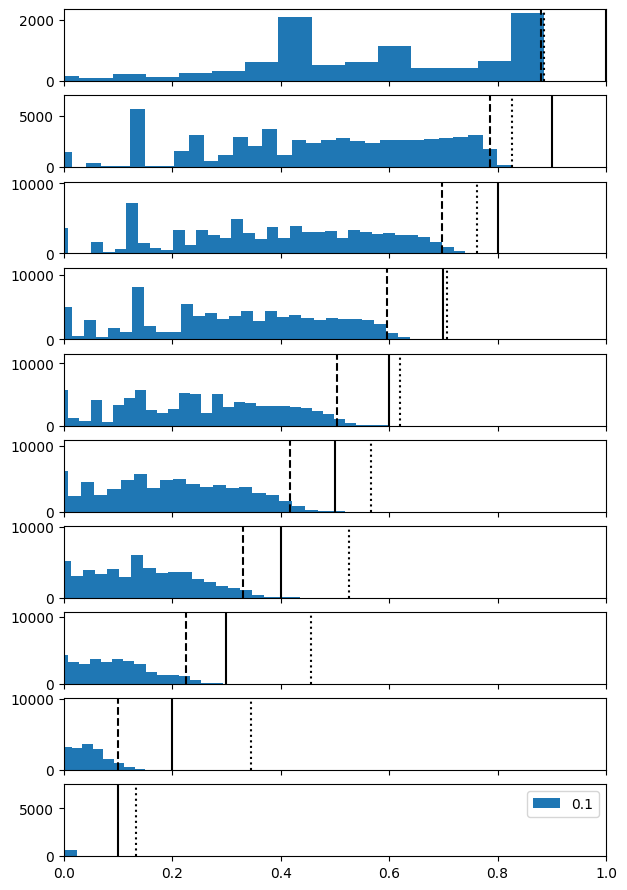

In [ ]:
drop_fractions = np.linspace(0, 1, 10, endpoint=False)
n_fractions = len(drop_fractions)
fig, axs = plt.subplots(n_fractions, 1, figsize=(7, n_fractions + 1), sharex=True)

for i, drop_fraction in enumerate(drop_fractions):
    pd = PositiveDropper(drop=drop_fraction, random_state=RANDOM_STATE)
    Xt, yt = pd.fit_resample(X, y)

    if sklearn.base.is_classifier(forest):
        if hasattr(forest, "oob_decision_function_"):
            proba = forest.fit(Xt, yt.reshape(-1)).oob_decision_function_
        else:
            proba = forest.fit(Xt, yt.reshape(-1)).predict_proba(Xt)
        proba = proba[:, 1]
    else:
        if hasattr(forest, "oob_prediction_"):
            proba = forest.fit(Xt, yt.reshape(-1)).oob_prediction_
        else:
            proba = forest.fit(Xt, yt.reshape(-1)).predict(Xt)

    positives_proba = proba[yt.astype(bool).reshape(-1)]

    c_estimates = np.concatenate(get_c_from_oob(forest, Xt, yt, delta=0.1))

    plt.xlim(0, 1)
    axs[i].hist(c_estimates, bins="auto", label=f"{1 - drop_fraction:.1f}")
    print("Done:", drop_fraction)

    axs[i].axvline(1 - drop_fraction, color="black", linestyle="-")
    axs[i].axvline(np.percentile(c_estimates, 99), color="black", linestyle="--")
    axs[i].axvline(c_estimates.max(), color="black", linestyle=":")

plt.legend()
